In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import os, re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

from tqdm import tqdm



In [13]:
import time

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

def test_clusters_agglomerative(tfidf_matrix, strategy, cluster_range, Z=None):
    """
    Test and plot metrics for agglomerative clustering for up to max_clusters.

    :param tfidf_matrix: TF-IDF matrix of the text data.
    :param strategy: Linkage criterion for Agglomerative Clustering ('ward', 'average', 'complete').
    :param max_clusters: Maximum number of clusters to test (default is 10).
    """
    # Perform Agglomerative Clustering
    if Z is None:
        # Timing the linkage execution
        start_time = time.time()
        if isinstance(tfidf_matrix, np.ndarray):
            Z = linkage(tfidf_matrix, method=strategy)
        else:
            Z = linkage(tfidf_matrix.toarray(), method=strategy)
        end_time = time.time()
        print(f"linkage executed in {(end_time - start_time):.2f} seconds")
        
    # Initialize lists to store metrics
    silhouette_scores_agg = []
    davies_bouldin_scores_agg = []

    for n_clusters in tqdm(cluster_range,total=len(cluster_range)):
        # Extracting labels for n clusters from the dendrogram
        labels = fcluster(Z, n_clusters, criterion='maxclust')
        
        # Silhouette Score
        silhouette_avg = silhouette_score(tfidf_matrix, labels, random_state=123)
        silhouette_scores_agg.append(silhouette_avg)
        
        # Davies-Bouldin Score
        db_score = davies_bouldin_score(tfidf_matrix, labels)
        davies_bouldin_scores_agg.append(db_score)

    # Plotting the metrics
    plt.figure(figsize=(10, 5))

    # Plot Silhouette Scores
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, silhouette_scores_agg, marker='o')
    plt.title(f'Silhouette Scores vs. Number of Clusters ({strategy})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    # Plot Davies-Bouldin Scores
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, davies_bouldin_scores_agg, marker='o')
    plt.title(f'Davies-Bouldin Scores vs. Number of Clusters ({strategy})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame.from_dict({'n_clusters':cluster_range, 'silhouette':silhouette_scores_agg, 'davies_bouldin':davies_bouldin_scores_agg}) 

In [14]:
res = []

for i in os.listdir('scores vs n_clusters - norm l2'):
    r = pd.read_csv(os.path.join('scores vs n_clusters - norm l2',i))
    r['rep'] = i.split('.')[0]
    res.append(r)

res = pd.concat(res,ignore_index=True)
res

,n_clusters,silhouette,davies_bouldin,rep
0,2,0.021819,6.184384,ngrams 1-1
1,3,0.027070,4.730004,ngrams 1-1
2,4,0.011988,5.118111,ngrams 1-1
3,5,-0.004949,5.699024,ngrams 1-1
4,6,-0.010263,5.393809,ngrams 1-1
...,...,...,...,...
227,26,0.008405,2.354057,word2vec tfidf 5
228,27,0.008998,2.352440,word2vec tfidf 5
229,28,0.009179,2.337229,word2vec tfidf 5
230,29,0.009681,2.369735,word2vec tfidf 5


In [15]:
reps = pd.unique(res.rep)
reps

array(['ngrams 1-1', 'ngrams 1-2', 'word2vec 10', 'word2vec 2',
       'word2vec 5', 'word2vec tfidf 10', 'word2vec tfidf 2',
       'word2vec tfidf 5'], dtype=object)

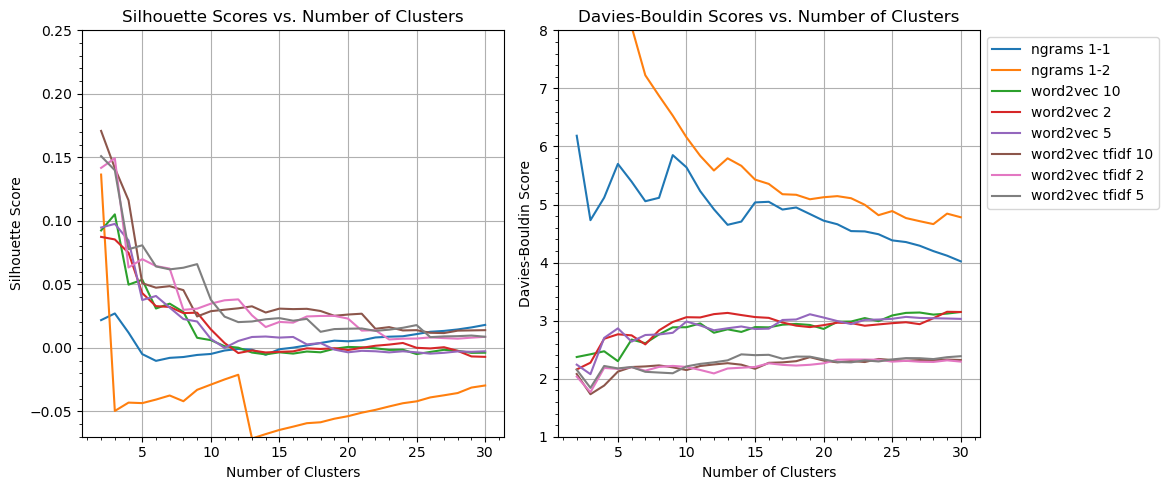

In [17]:
# Plotting the metrics
plt.figure(figsize=(10, 5))

# Plot Silhouette Scores
plt.subplot(1, 2, 1)

for i in reps:
    plt.plot(res.loc[res.rep == i,'n_clusters'], res.loc[res.rep == i,'silhouette'], marker=None, label=i)
plt.title(f'Silhouette Scores vs. Number of Clusters') #  ({strategy})
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.minorticks_on()
plt.ylim((-0.07, 0.25))
plt.grid(True)

# Plot Davies-Bouldin Scores
plt.subplot(1, 2, 2)
for i in reps:
    plt.plot(res.loc[res.rep == i,'n_clusters'], res.loc[res.rep == i,'davies_bouldin'], marker=None, label=i)
plt.title(f'Davies-Bouldin Scores vs. Number of Clusters') #  ({strategy})
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.minorticks_on()
plt.ylim((1, 8))
plt.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()